In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

In [3]:
# One-hot encoding for categorical attributes
def one_hot_encode(df):
    return pd.get_dummies(df)

In [5]:
# Decision Tree Definition
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Index of feature to split on
        self.threshold = threshold  # Threshold for numeric feature
        self.left = left  # Left child
        self.right = right  # Right child
        self.value = value  # Majority class label for leaf nodes


class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    # Calculate entropy of a dataset
    def entropy(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    # Calculate information gain
    def information_gain(self, X, y, feature, threshold):
        left_indices = X[:, feature] < threshold
        right_indices = ~left_indices
        left_entropy = self.entropy(y[left_indices])
        right_entropy = self.entropy(y[right_indices])
        parent_entropy = self.entropy(y)
        gain = parent_entropy - (
                    np.sum(left_indices) / len(y) * left_entropy + np.sum(right_indices) / len(y) * right_entropy)
        return gain

    # Split dataset based on a feature and threshold
    def split_dataset(self, X, y, feature, threshold):
        left_indices = X[:, feature] < threshold
        right_indices = ~left_indices
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]
        return X_left, y_left, X_right, y_right

    # Find best split for a node
    def find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self.information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    # Build decision tree recursively
    def build_tree(self, X, y, depth):
        # print("Depth:", depth)  # Debug print
        # print("Max Depth:", self.max_depth)  # Debug print
        if depth == 0 or len(np.unique(y)) == 1:
            return Node(value=np.bincount(y).argmax())

        best_feature, best_threshold = self.find_best_split(X, y)
        if best_feature is None:
            return Node(value=np.bincount(y).argmax())

        X_left, y_left, X_right, y_right = self.split_dataset(X, y, best_feature, best_threshold)
        left_child = self.build_tree(X_left, y_left, depth - 1)
        right_child = self.build_tree(X_right, y_right, depth - 1)

        return Node(best_feature, best_threshold, left_child, right_child)

    # Fit the decision tree to the training data
    def fit(self, X, y):
        self.tree = self.build_tree(X, y, depth)

    # Predict class labels for samples in X
    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    # Helper method for recursive prediction
    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self._predict(x, node.left)
        else:
            return self._predict(x, node.right)

In [7]:
# Stratified cross-validation
def fit(self, X, y):
    self.tree = self.build_tree(X, y, depth=self.max_depth)

def stratified_cross_validation(X, y, k, depth):
    folds_X = np.array_split(X, k)
    folds_y = np.array_split(y, k)
    accuracies = []
    f1_scores = []
    for i in range(k):
        X_train = np.concatenate([fold for j, fold in enumerate(folds_X) if j != i])
        y_train = np.concatenate([fold for j, fold in enumerate(folds_y) if j != i])
        X_test = folds_X[i]
        y_test = folds_y[i]

        model = DecisionTreeClassifier(max_depth=depth)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')

        accuracies.append(accuracy)
        f1_scores.append(f1)

    return accuracies, f1_scores

In [9]:
# Load dataset
data = pd.read_csv('loan.csv')
data.drop('Loan_ID', axis=1, inplace=True) # Drop Loan_ID
data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})
df_encoded = one_hot_encode(data)
X = df_encoded.drop('Loan_Status', axis=1).values
y = df_encoded['Loan_Status'].values

In [11]:
# Multiple iterations to collect accuracy and F1 scores
def multiple_iterations(X, y, iterations, depth):
    accuracies = []
    f1_scores = []
    for _ in range(iterations):
        # Randomly shuffle data to create different training and testing splits
        indices = np.arange(len(y))
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Perform stratified cross-validation as previously defined
        # Here assuming k=10 for stratified cross-validation
        iteration_accuracies, iteration_f1_scores = stratified_cross_validation(X_shuffled, y_shuffled, k=10,
                                                                                depth=depth)
        accuracies.append(np.mean(iteration_accuracies))
        f1_scores.append(np.mean(iteration_f1_scores))

    return accuracies, f1_scores

In [13]:
depth = 3
iterations = 100

accuracies, f1_scores = multiple_iterations(X, y, iterations, depth)

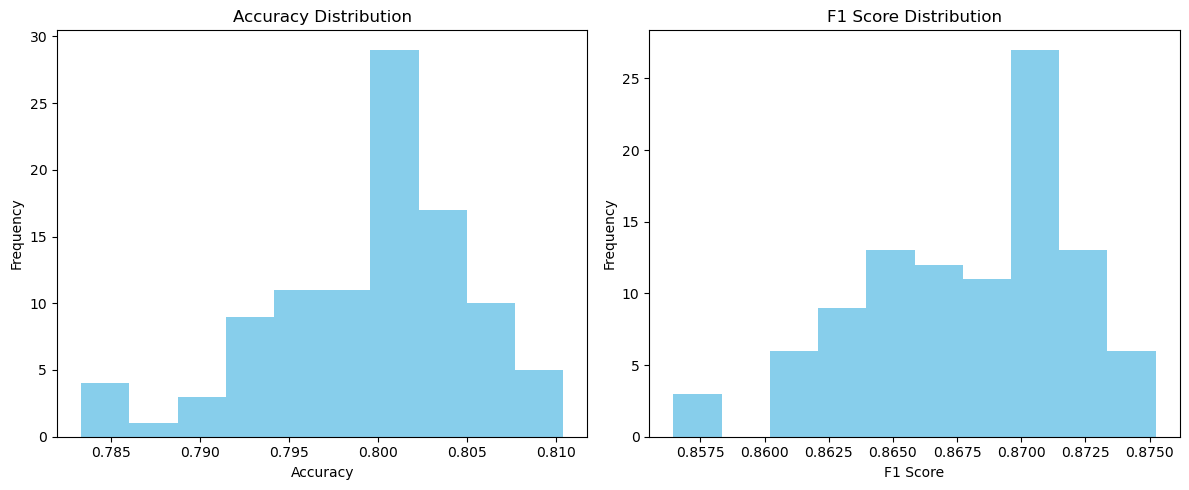

In [14]:
# Plotting histograms
plt.figure(figsize=(12, 5))

# Histogram for Accuracy
plt.subplot(1, 2, 1)
plt.hist(accuracies, bins=10, color='skyblue')
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Histogram for F1 Score
plt.subplot(1, 2, 2)
plt.hist(f1_scores, bins=10, color='skyblue')
plt.title('F1 Score Distribution')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate and print average and standard deviations
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

print("Summary Statistics for Accuracy:")
print(f"Mean Accuracy: {mean_accuracy:.4f}, Standard Deviation: {std_accuracy:.4f}")
print("Summary Statistics for F1 Score:")
print(f"Mean F1 Score: {mean_f1_score:.4f}, Standard Deviation: {std_f1_score:.4f}")